<a href="https://colab.research.google.com/github/UygarUsta/Codes/blob/main/Traffic_Sign_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [335]:
import os
if not os.path.exists('GTSRB'):
  !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
  !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
  !unzip -qq GTSRB_Final_Training_Images.zip
  !unzip -qq GTSRB_Final_Test_Images.zip
  !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
  

In [ ]:
!rm GTSRB_Final_Training_Images.zip
!rm GTSRB_Final_Test_Images.zip

In [337]:
import cv2
im = cv2.imread("/content/GTSRB/Final_Training/Images/7/00000_00020.ppm")

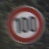

In [338]:
from google.colab.patches import cv2_imshow
cv2_imshow(im)

In [ ]:
for i,x in enumerate(sorted(os.listdir("/content/GTSRB/Final_Training/Images"))):
  
  name = os.path.join("/content/GTSRB/Final_Training/Images",x)
  new_name = os.path.join("/content/GTSRB/Final_Training/Images",str(i))
  os.rename(name,new_name)
  


In [340]:
import numpy as np
from glob import glob
import pandas as pd
from torch import optim
import torch
from torch import nn 
from torchvision import transforms as T
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import PIL
from PIL import Image

In [341]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [342]:
path = [ x for i in os.listdir("/content/GTSRB/Final_Training/Images/") for x in glob("/content/GTSRB/Final_Training/Images/"+i+"/*.ppm")]

In [343]:
from random import shuffle,seed
seed(42)
shuffle(path)

In [344]:
path[0].split("/")[-2]

'1'

In [345]:
train_path = path[:35000]
val_path = path[35000:]

In [346]:
class GTSRB(Dataset):
    def __init__(self,im,transform=None):
        
        self.im = im
        self.transform = transform
    def __len__(self):
        return len(self.im)
    def __getitem__(self,ix):
        im = cv2.imread(self.im[ix])[:,:,::-1]
        if self.transform:
          im = self.transform(im)
        target = int(self.im[ix].split("/")[-2])
        
        return im,torch.tensor(target).to(device)
    def collate_fn(self,batch):
        im,target = list(zip(*batch))
        if self.transform:
            im = [self.transform(img)[None].to(device) for img in im]
            target = [torch.tensor(label).to(device) for label in target]
            #im,target = [torch.cat(x).to(device) for x in [im,target]]
        return im,target
        
        

In [347]:
trn_tfms = T.Compose([
T.ToPILImage(),
T.Resize(224),
T.CenterCrop(224),
 T.ColorJitter(brightness=(0.8,1.2), # contrast=(0.8,1.2),
 saturation=(0.8,1.2),
 hue=0.25),
 T.RandomAffine(5, translate=(0.01,0.1)), 
T.ToTensor(),
T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
 

In [348]:
val_tfms = T.Compose([
                     T.ToPILImage(),
                     T.Resize(224),
                     T.CenterCrop(224),
                     T.ToTensor(),
                     T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
])

In [349]:
train = GTSRB(train_path,transform = trn_tfms)

In [350]:
val = GTSRB(val_path,transform = val_tfms)

In [351]:
train_dl = DataLoader(train,batch_size=32,shuffle = True)
val_dl = DataLoader(val,batch_size=32,shuffle = False)

In [430]:
im,label = next(iter(train_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


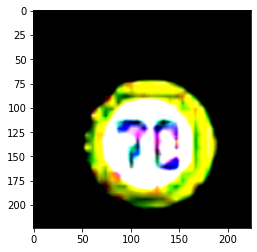

In [433]:
plt.imshow(im[5].squeeze(0).cpu().permute(1,2,0).numpy())

In [434]:
im,label = next(iter(val_dl))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


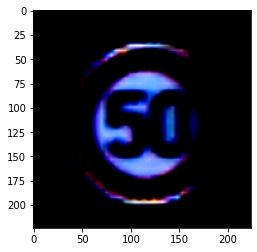

In [437]:
plt.imshow(im[18].squeeze(0).cpu().permute(1,2,0).numpy())

In [359]:
model = models.vgg16(pretrained = True)
for param in model.parameters():

  param.requires_grad = False

In [360]:
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

In [361]:
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512,128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128,43)
)

In [362]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [363]:

optimizer = optim.Adam(model.parameters(),lr = 1e-4)
loss_fn = nn.CrossEntropyLoss()

In [364]:
model = model.to(device)

In [367]:
from tqdm import tqdm 

In [369]:
train_losses,valid_losses= [],[]
n_epochs = 5

for epochs in tqdm(range(n_epochs)):

  train_loss = 0.0
  val_loss = 0.0
  model.train()
  for data,target in train_dl:
    data = data.to(device)
    target = target.to(device)
    
    optimizer.zero_grad()
    prediction = model(data)
    loss = loss_fn(prediction,target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * data.size(0)
    
  model.eval()
  for data,target in val_dl:
    data = data.to(device)
    target = target.to(device)

    prediction = model(data)
    loss = loss_fn(prediction,target)
    val_loss += loss.item() * data.size(0)
    
  train_loss = train_loss / len(train_dl.sampler)
  val_loss = val_loss / len(val_dl.sampler)
  train_losses.append(train_loss)
  valid_losses.append(val_loss)
  print("Epoch : {} \tTraining Loss: {:.6f} \tValidation Loss {:.6f}".format(epochs,train_loss,val_loss))



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [06:58<27:52, 418.01s/it]

Epoch : 0 	Training Loss: 2.076018 	Validation Loss 1.747086




 40%|████      | 2/5 [13:57<20:55, 418.48s/it]

Epoch : 1 	Training Loss: 1.751336 	Validation Loss 1.503623




 60%|██████    | 3/5 [20:55<13:56, 418.32s/it]

Epoch : 2 	Training Loss: 1.554710 	Validation Loss 1.334268




 80%|████████  | 4/5 [27:53<06:58, 418.32s/it]

Epoch : 3 	Training Loss: 1.414423 	Validation Loss 1.219444




100%|██████████| 5/5 [34:51<00:00, 418.37s/it]

Epoch : 4 	Training Loss: 1.299564 	Validation Loss 1.116755


In [420]:
sign = pd.read_csv("./signnames.csv")

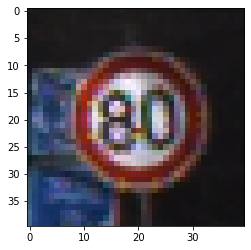

In [438]:
im_ = cv2.imread("/content/GTSRB/Final_Test/Images/00030.ppm")[:,:,::-1]
im = val.transform(im_)
plt.imshow(im_)

In [439]:
with torch.no_grad():
        output = model(im[None].to(device))
        output = torch.argmax(output,1)
        print(f"Predicted is {sign.SignName[output.cpu().numpy()[0]]}")

Predicted is Speed limit (80km/h)
